In [1]:
import os
from datetime import datetime
import shutil
from glob import glob
import rioxarray as rxr
from rioxarray.exceptions import NoDataInBounds
import rasterio.features
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
from rasterio.errors import NotGeoreferencedWarning
from scipy.ndimage import gaussian_filter
import importlib.util
from rioxarray.merge import merge_arrays
from scipy.optimize import minimize
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
np.seterr(divide='ignore', invalid='ignore')

def recreate_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def load_config(path):
    spec = importlib.util.spec_from_file_location("CFG", path)
    CFG = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(CFG)
    return CFG

In [2]:
DATA_DIR = "data/rybna_202203240654"
CFG = load_config(f"{DATA_DIR}/config.py")

In [3]:
#configure logging to file
import logging
log_path = f"{DATA_DIR}/logs/calibration_{datetime.now().strftime('%d%m%Y%H%M%S')}.log"
os.makedirs(os.path.dirname(log_path), exist_ok=True)
logging.basicConfig(filename=log_path,level=logging.INFO, format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.handlers.clear()
logger.addHandler(logging.StreamHandler())
logger.info("Starting procedure")

Starting procedure


In [24]:
# EROSION = 5 #meters
# CRS = "EPSG:32634"
TMP_DIR = f"{DATA_DIR}/tmp"
recreate_dir(TMP_DIR)
TIFF_DIR = f"{DATA_DIR}/tiff"
assert os.path.exists(TIFF_DIR), "tiff_dir does not exist. Please run 1_conversion.ipynb first."
GEOTIFF_OPTIM_DIR = f"{DATA_DIR}/geotiff_optim"
assert os.path.exists(GEOTIFF_OPTIM_DIR), "geotiff_dir does not exist. Please run 1_conversion.ipynb first."
TIFF_CAL_DIR = f"{DATA_DIR}/tiff_cal"
GEOTIFF_CAL_DIR = f"{DATA_DIR}/geotiff_cal"
PLOT_CLIP_DIR = f"{DATA_DIR}/plot_clip"
PLOT_CAL_DIR = f"{DATA_DIR}/plot_cal"

In [5]:
logger.info("Reading footprints")
geometries = []
names = []
for path in tqdm(glob(f"{GEOTIFF_OPTIM_DIR}/*.tiff")):
    raster = rxr.open_rasterio(path)
    footprints = rasterio.features.shapes((raster != raster.rio.nodata).values.astype(np.int16), transform=raster.rio.transform())
    footprints = [Polygon(geom["coordinates"][0]).simplify(10).buffer(-CFG.EROSION) for geom, colval in footprints if colval == 1]
    assert len(footprints) == 1, "More than one footprint found"
    names.append(os.path.basename(path))
    geometries.append(footprints[0])
footprints = gpd.GeoDataFrame({"name": names, "geometry": geometries})

Reading footprints
100%|██████████| 890/890 [02:31<00:00,  5.88it/s]


In [6]:
logger.info("Detecting intersections")
inters = []
# geometries_buf = []
for i, i_geom in tqdm(footprints["geometry"].items()):
    inter = []
    for j, j_geom in footprints["geometry"].items():
        if i == j:
            continue
        if i_geom.intersects(j_geom):
            area = i_geom.intersection(j_geom).area
            inter.append({"id": j,"area": area})
    inter = sorted(inter, key=lambda k: k['area'], reverse=True)
    inters.append(inter)
    # geometries_buf.append(i_geom)
# footprints['geometry'] = geometries_buf
footprints['intersect'] = inters

Detecting intersections
890it [00:11, 74.86it/s]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

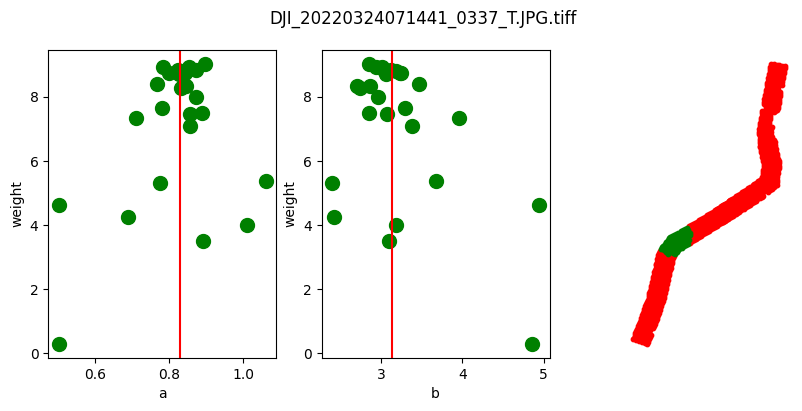

Calibrated:: a: 0.8293662652766903, b: 3.1279692595131623, weight: 7.1207990646362305
  9%|▊         | 76/889 [34:13<8:30:15, 37.66s/it]
Calibrating:: dst: DJI_20220324070227_0097_T.JPG.tiff
Matching:: src: DJI_20220324070230_0098_T.JPG.tiff


    1 image files updated


False; Maximum number of function evaluations has been exceeded.
a: 0.6803595689964935, b: 2.446169635356945, weight: 4.6837053298950195
Matching:: src: DJI_20220324070735_0198_T.JPG.tiff
True; Optimization terminated successfully.
a: 0.6616498015641011, b: 2.8580198148044644, weight: 5.094195365905762
Matching:: src: DJI_20220324070738_0199_T.JPG.tiff
True; Optimization terminated successfully.
a: 0.6572252734525006, b: 2.6470860070533884, weight: 4.954871654510498
Matching:: src: DJI_20220324071003_0245_T.JPG.tiff
True; Optimization terminated successfully.
a: 0.6450544469140164, b: 2.3849601664208864, weight: 5.6692657470703125
Matching:: src: DJI_20220324070233_0099_T.JPG.tiff
True; Optimization terminated successfully.
a: 0.6998470872330187, b: 2.3074077600431884, weight: 5.041019439697266
Matching:: src: DJI_20220324070732_0197_T.JPG.tiff
True; Optimization terminated successfully.
a: 0.6530141163748656, b: 3.1163426501686375, weight: 5.378353118896484
Matching:: src: DJI_2022032

ValueError: arange: cannot compute length

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
logger.info(f"Clearing {TIFF_CAL_DIR}")
recreate_dir(TIFF_CAL_DIR)
logger.info(f"Clearing {GEOTIFF_CAL_DIR}")
recreate_dir(GEOTIFF_CAL_DIR)
logger.info(f"Clearing {PLOT_CLIP_DIR}")
recreate_dir(PLOT_CLIP_DIR)
logger.info(f"Clearing {PLOT_CAL_DIR}")
recreate_dir(PLOT_CAL_DIR)

logger.info("Initializing columns")
footprints['a_std']=None
footprints['b_std']=None
footprints['weight']=None
footprints['a']=None
footprints['b']=None
footprints['calibrated']=False

logger.info("Setting start refrence img")
name = CFG.START_IMG
raster = rxr.open_rasterio(os.path.join(GEOTIFF_OPTIM_DIR, name), masked=True)
raster.rio.to_raster(os.path.join(GEOTIFF_CAL_DIR, name))
footprints.loc[footprints['name'] == name, 'offset'] = 0
footprints.loc[footprints['name'] == name, 'calibrated'] = True
footprints.loc[footprints['name'] == name, 'std'] = 0.0
footprints.loc[footprints['name'] == name, 'weight'] = None
start_point = footprints.loc[footprints['name'] == name, 'geometry'].centroid.values[0]
logger.info("Setting the calibration order")
id_dists = []
for id_i, row_i in tqdm(footprints.iterrows()):
    dist = row_i['geometry'].centroid.distance(start_point)
    if not row_i['calibrated']:
        id_dists.append({"id": id_i, "dist": dist})
id_dists = sorted(id_dists, key=lambda k: k['dist'])

def nan_gaussian_filter(arr, sigma):
    """Apply gaussian filter to array while ignoring nans"""
    V=arr.copy()
    V[np.isnan(arr)]=0
    VV=gaussian_filter(V,sigma=sigma)
    W=0*arr.copy()+1
    W[np.isnan(arr)]=0
    WW=gaussian_filter(W,sigma=sigma)
    Z=VV/WW
    Z[np.isnan(arr)]=np.nan
    return Z

# def loss_function(x, src_hist, dst_hist):
#     dst_y_new = np.interp(src_hist["x"], x[0]*dst_hist["x"]+x[1], dst_hist["y"], left=0.0, right=0.0)
#     mae = np.mean(np.abs(src_hist["y"]-dst_y_new))
#     return mae

def loss_function(x, src_arr, dst_arr):
    mse = np.nanmean((src_arr - (x[0]*dst_arr+x[1]))**2)
    return mse

def calc_hist(arr):
    min_val = np.floor(np.nanmin(arr)*10)/10
    max_val = np.ceil(np.nanmax(arr)*10)/10
    bins =  np.arange(min_val, max_val, 0.1)
    histogram = np.histogram(arr, bins=bins, density=False)
    x = histogram[1][:-1]
    y = histogram[0]
    # interpolate to 0.01
    # x_new = np.arange(min_val, max_val, 0.01)
    # y_new = np.interp(x_new, x, y)
    return {"x": x, "y": y}

logger.info("Calibrating pairs")
for id_dist in tqdm(id_dists):
    dst_id = id_dist['id']
    dst = footprints.iloc[dst_id]
    if dst['calibrated']:
        logger.info(f"{dst['name']} already calibrated, skipping")
        continue
    dst_raster = rxr.open_rasterio(f"{GEOTIFF_OPTIM_DIR}/{dst['name']}", masked=True)
    a_arr = []
    b_arr = []
    weights = []
    logger.info(f"")
    logger.info(f"Calibrating:: dst: {dst['name']}")
    for inter in footprints.iloc[dst_id]['intersect']:
        if footprints.iloc[inter['id']]['calibrated']:
            src_id = inter['id']
            src = footprints.iloc[src_id]
            src_raster = rxr.open_rasterio(f"{GEOTIFF_CAL_DIR}/{src['name']}", masked=True)#.rio.clip([dst['geometry']])
            logger.info(f"Matching:: src: {src['name']}")
            intersection = src['geometry'].intersection(dst['geometry'])
            try:
                src_clip = src_raster.rio.clip([intersection])
                dst_clip = dst_raster.rio.clip([intersection])
            except NoDataInBounds:
                logger.info(f"NoDataInBounds")
                continue
            dst_clip = dst_clip.rio.reproject_match(src_clip)
            src_clip = src_clip.values[0]
            dst_clip = dst_clip.values[0]

            src_clip = nan_gaussian_filter(src_clip, sigma=CFG.GAUSS_SIGMA)
            dst_clip = nan_gaussian_filter(dst_clip, sigma=CFG.GAUSS_SIGMA)
            src_hist = calc_hist(src_clip)
            dst_hist = calc_hist(dst_clip)
            result = minimize(loss_function, x0=(1.0,0.0), args=(src_clip, dst_clip), tol=1e-3, method='Powell', bounds=[(0.5,1.5),(-10.,10.)])
            logger.info(f"{result.success}; {result.message}")
            a = result.x[0]
            b = result.x[1]
            #plot src_hist, dst_hist, dst_hist_new on one plot using line
            # plt.plot(src_hist["x"], src_hist["y"], label="src")
            # plt.plot(dst_hist["x"], dst_hist["y"], label="dst")
            # plt.plot(a*dst_hist["x"]+b, dst_hist["y"], label="dst_new")
            # plt.legend()
            # plt.savefig(f"{HIST_DIR}/{dst['name'][:-5]}_{src['name'][:-5]}.png")
            # # clear plot
            # plt.clf()
            # diff = (src_clip-dst_clip)
            # diff_before = diff.copy()
            # #remove values outside of 1 std in 2d array
            # diff[np.abs(diff - np.nanmean(diff)) > np.nanstd(diff)] = np.nan
            # #plot src_clip, dst_clip, diff_before, diff images
            # 4 subplots
            dst_clip_cal = a*dst_clip+b
            diff = src_clip - dst_clip_cal
            dst_cal_hist = calc_hist(dst_clip_cal)
            fig, ax = plt.subplots(2,2)
            #title
            fig.suptitle(f"a={a}, b={b}")
            ax[0,0].imshow(src_clip)
            ax[0,1].imshow(dst_clip)
            diff_plt = ax[1,0].imshow(diff, cmap='coolwarm')
            plt.colorbar(diff_plt, ax=ax[1,0])
            ax[1,1].plot(src_hist["x"], src_hist["y"], label="src", color='blue', linestyle='dashed')
            ax[1,1].plot(dst_hist["x"], dst_hist["y"], label="dst", color='red')
            ax[1,1].plot(dst_cal_hist["x"], dst_cal_hist["y"], label="dst_cal", color='green')
            plt.legend()
            plt.savefig(f"{PLOT_CLIP_DIR}/{dst['name'][:-5]}_{src['name'][:-5]}.png", dpi=150)
            plt.clf()
            # im1 = ax[1,0].imshow(diff_before, cmap='coolwarm')
            # bar1 = plt.colorbar(im1, ax=ax[1,0])
            # im2 = ax[1,1].imshow(diff, cmap='coolwarm')
            # bar2 = plt.colorbar(im2, ax=ax[1,1])
            # #save plot to file
            #plt.savefig(f"{CLIP_DIR}/{dst['name'][:-5]}_{src['name'][:-5]}.png")
            #clear plot
            
            weight = np.nanstd(src_clip)+np.nanstd(dst_clip)#inter['area']#1./ #1/result.fun
            #logger.info(f"{weight} (weight) = {src['std']} (source STD))
            # offset = np.nanmean(diff)
            #assert offset is not nan
            if np.isnan(a) or np.isnan(b):
                logger.info(f"a or b is nan")
                continue
            logger.info(f"a: {a}, b: {b}, weight: {weight}")
            a_arr.append(a)
            b_arr.append(b)
            # offsets.append(offset)
            weights.append(weight)
        
    a_arr = np.array(a_arr)
    b_arr = np.array(b_arr)
    weights = np.array(weights)
    # offsets_all = offsets.copy()
    # weights_all = weights.copy()
    # if len(offsets) > 1:
    #     indices = np.abs(offsets - np.mean(offsets)) < 2*np.std(offsets) #remove outliers
    #     offsets = offsets[indices]
    #     weights = weights[indices]
    weight = weights.mean()
    a = (a_arr*weights).sum()/weights.sum()
    b = (b_arr*weights).sum()/weights.sum()

    #Display
    display.clear_output(wait=True)
    #create two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
    # set figure title
    fig.suptitle(f"{dst['name']}")
    #plot offsets against weights
    #ax1.scatter(offsets_all, weights_all, s=100, color='red')
    ax1.scatter(a_arr, weights, s=100, color='green')
    ax1.set_xlabel('a')
    ax1.set_ylabel('weight')
    ax1.axvline(a, color='r')
    ax2.scatter(b_arr, weights, s=100, color='green')
    ax2.set_xlabel('b')
    ax2.set_ylabel('weight')
    ax2.axvline(b, color='r')
    # plot points
    #plot footprints centroids where calibrated=False
    footprints[footprints['calibrated']==False].centroid.plot(ax=ax3, color='red', markersize=10)
    #plot footprints centroids where calibrated=True
    footprints[footprints['calibrated']==True].centroid.plot(ax=ax3, color='green', markersize=10)
    #hide axis
    ax3.axis('off')
    plt.savefig(f"{PLOT_CAL_DIR}/{dst['name'][:-5]}.png")
    plt.show()
    #save figure
   
    a_std = np.sqrt(np.average((a_arr-a)**2, weights=weights)) if len(a_arr) > 1 else 0.0
    b_std = np.sqrt(np.average((b_arr-b)**2, weights=weights)) if len(b_arr) > 1 else 0.0
    #std = np.std(offsets) if len(offsets) > 1 else 0.0
    footprints.loc[dst_id, 'a_std'] = a_std
    footprints.loc[dst_id, 'b_std'] = b_std
    footprints.loc[dst_id, 'weight'] = weight
    footprints.loc[dst_id, 'a'] = a
    footprints.loc[dst_id, 'b'] = b
    footprints.loc[dst_id, 'calibrated'] = True
    dst_raster.values = a*dst_raster.values + b
    dst_raster.rio.to_raster(f"{GEOTIFF_CAL_DIR}/{dst['name']}")
    tiff = rxr.open_rasterio(f"{TIFF_DIR}/{dst['name']}")
    tiff.values = (a*tiff.values+b)
    tiff.rio.to_raster(f"{TIFF_CAL_DIR}/{dst['name']}")
    os.system(f"exiftool -tagsfromfile {TIFF_DIR}/{dst['name']} {TIFF_CAL_DIR}/{dst['name']} -overwrite_original_in_place")
    logger.info(f"Calibrated:: a: {a}, b: {b}, weight: {weight}")

In [30]:
src_clip

array([[8.332662,      nan,      nan,      nan,      nan,      nan,
             nan,      nan],
       [     nan, 8.333278, 8.333836,      nan,      nan,      nan,
             nan,      nan],
       [     nan,      nan, 8.334128, 8.33461 ,      nan,      nan,
             nan,      nan],
       [     nan,      nan, 8.334237, 8.33441 , 8.334541,      nan,
             nan,      nan],
       [     nan,      nan,      nan, 8.33382 , 8.333628, 8.333477,
             nan,      nan],
       [     nan,      nan,      nan, 8.332919, 8.332481, 8.332165,
        8.331984, 8.33191 ],
       [     nan,      nan,      nan,      nan, 8.331397, 8.331004,
        8.330789,      nan],
       [     nan,      nan,      nan,      nan,      nan, 8.330316,
             nan,      nan]], dtype=float32)

Merge rasters

In [ ]:
def average_merge(merged_data, new_data, merged_mask, new_mask, index=None, roff=None, coff=None):
    merged_data_masked = np.ma.array(merged_data, mask=merged_mask)
    merged_data[:] = np.ma.masked_array((merged_data_masked,new_data)).mean(axis=0)
rasters = []
for path in tqdm(glob(f"{GEOTIFF_CAL_DIR}/*.tiff"), desc="Loading rasters"):
    rasters.append(rxr.open_rasterio(path, masked=True).copy())
print("Merging...")
mosaic = merge_arrays(rasters, method=average_merge)
mosaic.rio.to_raster(f"{DATA_DIR}/mosaic_cal.tiff")
print("Merging done")

: 